# Agent를 이용한 Corrective RAG

https://github.com/kyopark2014/llm-agent/blob/main/corrective-rag-agent.md

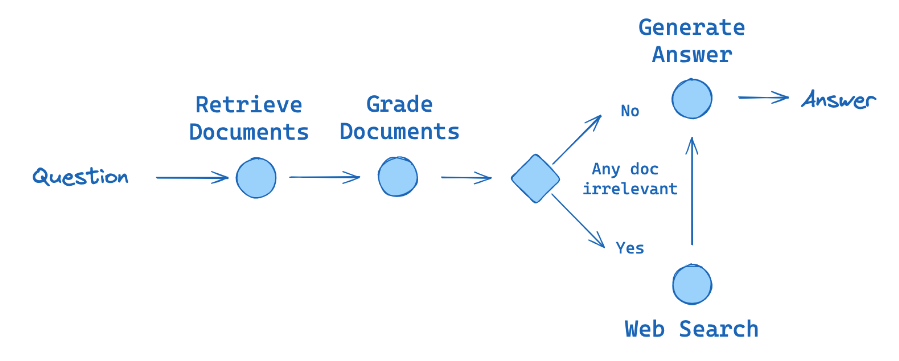

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [14]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

from langchain_community.embeddings import BedrockEmbeddings
embedding_model_id = "amazon.titan-embed-text-v2:0"
bedrock_embedding = BedrockEmbeddings(
    client=boto3_bedrock,
    region_name = bedrock_region,
    model_id = embedding_model_id
) 

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [9]:
!pip install -U tavily-python --quiet

In [10]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [12]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Corrective-RAG"

In [13]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="이미지를 분석하기 위한 서비스에 대해 설명해줘."
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. 

주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 분류합니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.

텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 전체적인 내용을 분류하고 레이블을 붙입니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 검출하는 기능입니다.

이런 기능들을 활용하면 이미지에서 유용한 정보를 자동으로 추출할 수 있어 다양한 분야에서 활용될 수 있습니다. 제가 더 자세히 설명드릴 부분이 있다면 말씀해 주세요.

'안녕하세요. 이미지 분석 서비스에 대해 설명해 드리겠습니다. 이미지 분석 서비스는 컴퓨터 비전과 머신러닝 기술을 활용하여 이미지에서 다양한 정보를 추출하고 분석하는 서비스입니다. \n\n주요 기능으로는 객체 인식, 얼굴 인식, 텍스트 인식, 이미지 분류, 콘텐츠 모더레이션 등이 있습니다. 객체 인식은 이미지 내에 있는 사물이나 사람 등의 객체를 인식하고 분류합니다. 얼굴 인식은 이미지에서 사람의 얼굴을 찾아내고 연령, 감정 등의 속성을 분석합니다.\n\n텍스트 인식은 이미지 내 텍스트 영역을 찾아 텍스트를 추출합니다. 이미지 분류는 이미지의 전체적인 내용을 분류하고 레이블을 붙입니다. 콘텐츠 모더레이션은 부적절한 콘텐츠를 검출하는 기능입니다.\n\n이런 기능들을 활용하면 이미지에서 유용한 정보를 자동으로 추출할 수 있어 다양한 분야에서 활용될 수 있습니다. 제가 더 자세히 설명드릴 부분이 있다면 말씀해 주세요.'

In [17]:
!pip install faiss-cpu --quiet

In [131]:
# English URL
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

In [132]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores.faiss import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Korean URL
urls = [
    "https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/what-is.html",
    "https://docs.aws.amazon.com/ko_kr/athena/latest/ug/glue-athena.html"
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

In [109]:
doc_splits[0]

Document(metadata={'source': 'https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html', 'title': 'Amazon Bedrock이란 무엇인가요? - Amazon Bedrock', 'description': 'Amazon BedRock 서비스에 대한 개요를 제공합니다.', 'language': 'ko-KR'}, page_content='Amazon Bedrock이란 무엇인가요? - Amazon BedrockAmazon Bedrock이란 무엇인가요? - Amazon BedrockAWSaws-documentationAmazon Bedrock사용자 가이드Amazon Bedrock의 기능Amazon BedRock 요금기계 번역으로 제공되는 번역입니다. 제공된 번역과 원본 영어의 내용이 상충하는 경우에는 영어 버전이 우선합니다.Amazon Bedrock이란')

In [110]:
docs_list

[Document(metadata={'source': 'https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html', 'title': 'Amazon Bedrock이란 무엇인가요? - Amazon Bedrock', 'description': 'Amazon BedRock 서비스에 대한 개요를 제공합니다.', 'language': 'ko-KR'}, page_content='\nAmazon Bedrock이란 무엇인가요? - Amazon BedrockAmazon Bedrock이란 무엇인가요? - Amazon BedrockAWSaws-documentationAmazon Bedrock사용자 가이드Amazon Bedrock의 기능Amazon BedRock 요금기계 번역으로 제공되는 번역입니다. 제공된 번역과 원본 영어의 내용이 상충하는 경우에는 영어 버전이 우선합니다.Amazon Bedrock이란 무엇인가요?Amazon Bedrock은 선도적인 AI 스타트업과 Amazon의 고성능 파운데이션 모델(FM)을 통합 API를 통해 사용할 수 있게 해주는 완전 관리형 서비스입니다. 다양한 파운데이션 모델 중에서 선택하여 사용 사례에 가장 적합한 모델을 찾을 수 있습니다. 또한 Amazon Bedrock은 보안, 프라이버시 및 책임감 있는 AI를 갖춘 생성형 AI 애플리케이션을 구축할 수 있는 다양한 기능을 제공합니다. Amazon Bedrock을 사용하면 사용 사례에 맞는 최고 수준의 파운데이션 모델을 쉽게 실험 및 평가하고, 미세 조정 및 검색 증강 생성(RAG)과 같은 기술로 데이터를 사용하여 프라이빗으로 사용자 지정하고, 엔터프라이즈 시스템 및 데이터 소스를 사용하여 작업을 실행하는 에이전트를 구축할 수 있습니다.Amazon Bedrock의 서버리스 환경을 사용하면 인프라를 관리할 필요 없이 빠르게 시작하고, 자체 데이터로 기초 모델을 비공개로 사용자 지정하고, AWS 도구를 사용하여 쉽고 안

In [111]:
# Add to vectorDB
vectorstore = FAISS.from_documents(
    doc_splits,
    bedrock_embedding,
)
retriever = vectorstore.as_retriever()

In [112]:
from langchain_core.pydantic_v1 import BaseModel, Field

class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

structured_llm_grader = chat.with_structured_output(GradeDocuments)

In [113]:
# Prompt 
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

In [114]:
retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
docs = retriever.invoke(question)

In [115]:
doc_txt = docs[1].page_content
doc_txt

'부적절하거나 원치 않는 콘텐츠 방지 — 가드레일을 사용하여 제너레이티브 AI 애플리케이션을 위한 보호 장치를 구현하십시오.'

In [116]:
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='no'


In [117]:
system = (
#"""다음의 <context> tag안의 참고자료를 이용하여 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다. Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.
"""Here is pieces of context, contained in <context> tags. Provide a concise answer to the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.
                        
<context>
{context}
</context>""")
human = "{question}"
    
prompt = ChatPromptTemplate.from_messages([("system", system), ("human", human)])
                   
rag_chain = prompt | chat

In [118]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

content='죄송합니다만 제공된 컨텍스트에는 에이전트 메모리에 대한 정보가 없습니다. Amazon Bedrock 서비스의 개요만 설명되어 있을 뿐입니다.' additional_kwargs={'usage': {'prompt_tokens': 842, 'completion_tokens': 76, 'total_tokens': 918}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 842, 'completion_tokens': 76, 'total_tokens': 918}, 'stop_reason': 'end_turn', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} id='run-05e60e3a-041f-4c51-9497-aad46a481b02-0' usage_metadata={'input_tokens': 842, 'output_tokens': 76, 'total_tokens': 918}


## Web Search Tool

In [119]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

## Graph state

In [120]:
from typing_extensions import TypedDict
from typing import List

class GraphState(TypedDict):
    question : str
    generation : str
    web_search : str
    documents : List[str]

In [121]:
from langchain.schema import Document

def retrieve(state: GraphState):
    print("###### retrieve ######")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    print("document[0]: ", documents[0])
    
    return {"documents": documents, "question": question}

In [122]:
def grade_documents(state: GraphState):
    print("###### grade_documents ######")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No"
    for doc in documents:
        score = retrieval_grader.invoke({"question": question, "document": doc.page_content})
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    print('len(docments): ', len(filtered_docs))
    print('web_search: ', web_search)
    
    return {"question": question, "documents": filtered_docs, "web_search": web_search}

In [123]:
def decide_to_generate(state: GraphState):
    print("###### decide_to_generate ######")
    question = state["question"]
    filtered_documents = state["documents"]
    web_search = state["web_search"]
    
    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

In [124]:
def generate(state: GraphState):
    print("###### generate ######")
    question = state["question"]
    documents = state["documents"]
    
    # RAG generation
    generation = rag_chain.invoke({"context": docs, "question": question})
    print('generation: ', generation.content)
    
    return {"documents": documents, "question": question, "generation": generation}

In [125]:
def web_search(state: GraphState):
    print("###### web_search ######")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    
    if documents is not None:
        documents.append(web_results)
    else:
        documents = [web_results]
    
    return {"question": question, "documents": documents}

### Build Graph

In [126]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("websearch", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("generate", END)

# Compile
app = workflow.compile()

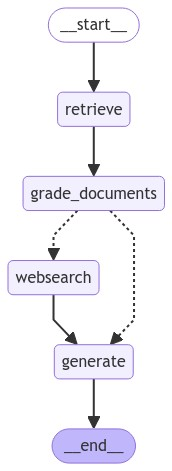

In [127]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [128]:
from pprint import pprint
inputs = {"question": "What are the types of agent memory?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='프롬프트와 구성으로 실험 - 모델 추론 실행에서 다양한 구성 및 파운데이션 모델을 사용하여 프롬프트를 전송하여 응답을 생성합니다. API 또는 콘솔의 텍스트, 이미지, 채팅 플레이그라운드를 사용하여 그래픽' metadata={'source': 'https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html', 'title': 'Amazon Bedrock이란 무엇인가요? - Amazon Bedrock', 'description': 'Amazon BedRock 서비스에 대한 개요를 제공합니다.', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
len(docments):  0
web_search:  Yes
###### decide_to_generate ######
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
###### web_search ######
'Finished running: websearch:'
###### generate ######
generation:  이 문서에는 Amazon Bedrock 서비스에 대한 일반적인 설명만 포함되어 있으며 에이전트 메모리 유형에 대한 정보는 없습니다. 에이전트 메모리 유형에 대해서는 알려진 바가 없습니다.
'Finished running: gene

In [129]:
inputs = {"question": "How does the AlphaCodium paper work?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='고객 지원 방법을 통해 추론하는 애플리케이션 생성 - 파운데이션 모델을 사용하고, API 직접 호출을 만들고, 필요에 따라 지식 기반을 쿼리하여 고객을 위한 작업을 수행하는 에이전트를 구축합니다.' metadata={'source': 'https://docs.aws.amazon.com/ko_kr/bedrock/latest/userguide/what-is-bedrock.html', 'title': 'Amazon Bedrock이란 무엇인가요? - Amazon Bedrock', 'description': 'Amazon BedRock 서비스에 대한 개요를 제공합니다.', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
len(docments):  0
web_search:  Yes
###### decide_to_generate ######
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, INCLUDE WEB SEARCH---
'Finished running: grade_documents:'
###### web_search ######
'Finished running: websearch:'
###### generate ######
generation:  죄송합니다만 제공된 컨텍스트에는 AlphaCodium 논문에 대한 내용이 없습니다. 따라서 AlphaCodium 논문이 어떻게 작동하는지에 대해서는 알려드릴 수 없습니다.
'Finished running: generate:'
AIMessa

In [130]:
inputs = {"question": "Aver의 Glue는 무엇이지?"}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")
pprint(value["generation"])

###### retrieve ######
document[0]:  page_content='AWS Glue와의 통합 - Amazon AthenaAWS Glue와의 통합 - Amazon AthenaAWSaws-documentationAmazon Athena사용자 가이드AWS Glue와의 통합 교차 계정 액세스AWS Glue는 완전관리형 추출, 변환, 로드 AWS 서비스입니다. 주요 기능 중 하나는 데이터를 분석하고 분류하는 것입니다. AWS Glue 크롤러를' metadata={'source': 'https://docs.aws.amazon.com/ko_kr/athena/latest/ug/glue-athena.html', 'title': 'AWS Glue와의 통합 - Amazon Athena', 'description': 'Athena가 어떻게 AWS Glue와 작동하는지 알아보세요.', 'language': 'ko-KR'}
'Finished running: retrieve:'
###### grade_documents ######
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
len(docments):  4
web_search:  No
###### decide_to_generate ######
---DECISION: GENERATE---
'Finished running: grade_documents:'
###### generate ######
generation:  제공된 컨텍스트에는 Amazon Bedrock 서비스에 대한 설명만 있고 Aver의 Glue에 대한 정보는 없습니다. 따라서 이 질문에 대한 답변을 할 수 없습니다.
'Finished running: generate:'
AIMessage(content='제공된 컨텍스트에는 Amazon Bedrock 서비스에 대한 설명만 있고 Av